In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

from IPython.display import Markdown
def bold(string):
    display(Markdown(string))
    
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, KFold

from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

In [2]:
train = pd.read_csv(r'.\Data\problem_train.csv')
test = pd.read_csv(r'.\Data\problem_test.csv')

labels = pd.read_csv(r'.\Data\problem_labels.csv')

In [3]:
train = train.drop('id', axis=1)
test = test.drop('id', axis=1)
labels = labels.drop('id', axis=1)


train_nas = train.iloc[:, list(train.isnull().sum() / len(train) * 100 == 100)].columns
test_nas = test.iloc[:, list(test.isnull().sum() / len(test) * 100 == 100)].columns
nas_cols = list(set(train_nas) | set(test_nas))

train = train.drop(nas_cols, axis=1)
test = test.drop(nas_cols, axis=1)


train_dropped = []
for col in train.columns:
    if (train[col].isnull().sum() <= 1000) & (len(train[col].value_counts()) == 1) or \
        (train[col].isnull().sum() == train.shape[0]):
            train_dropped.append(col)
            train = train.drop(col, axis=1)
            
test_dropped = []
for col in test.columns:
    if (test[col].isnull().sum() <= 1000) & (len(test[col].value_counts()) == 1) or \
        (test[col].isnull().sum() == test.shape[0]):
            test_dropped.append(col)
            test = test.drop(col, axis=1)
            
            
cols_to_drop = []
for col in train.columns:
    if len(train[col].value_counts()) == 1:
        if train[col].value_counts()[train[col].value_counts().keys()[0]] == train.shape[0]:
            cols_to_drop.append(col)
print(cols_to_drop)

cols_to_drop = []
for col in test.columns:
    if len(test[col].value_counts()) == 1:
        if test[col].value_counts()[test[col].value_counts().keys()[0]] == test.shape[0]:
            cols_to_drop.append(col)
print(cols_to_drop)
            
sorted(train.columns) == sorted(test.columns)

[]
[]


True

In [4]:
train_noNas = list(train.iloc[:, list(train.isnull().any() == False)].columns)
test_noNas = list(test.iloc[:, list(test.isnull().any() == False)].columns)
noNAs = list(set(train_noNas) & set(test_noNas))

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

---

## Model I.1

Давайте посмотрим, что будет, если NaNs заменить 0мя или '' (в зависимости от типа), на веса лог регресии это не повлияет (но catboost все же тоже протестируем).

In [5]:
train_zeros = train.copy()

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_cols = train_zeros.select_dtypes(include=numerics).columns
train_zeros[num_cols] = train_zeros[num_cols].fillna(0)

str_cols = train_zeros.select_dtypes(include='object').columns
train_zeros[str_cols] = train_zeros[str_cols].fillna('')

train_zeros.head()

,release,n_0000,n_0001,n_0002,n_0003,n_0004,n_0005,n_0006,n_0007,n_0009,...,c_1366,c_1367,c_1369,c_1370,c_1372,c_1373,c_1374,c_1375,c_1376,c_1377
0,a,0.0,0.0,0.025449,0.0,0.0,0.368421,0.0,0.0,0.0,...,,,,,a,,q,,,
1,a,0.0,0.0,0.031297,0.0,0.0,0.315789,0.0,0.0,0.0,...,,,,a,a,,,,,
2,a,0.0,0.0,0.024475,0.0,0.0,0.342105,0.0,0.0,0.0,...,,,,a,a,,b,,,
3,a,0.0,0.0,0.041694,0.0,0.0,0.447368,0.0,0.0,0.0,...,,,,,a,,,,,
4,c,0.0,0.0,0.038120,0.0,0.0,0.315789,0.0,0.0,0.0,...,,,,b,a,,a,,,


In [6]:
train_zeros_ohe = OneHotEncoder(handle_unknown="ignore").fit_transform(train_zeros[str_cols])
train_zeros_ohe = pd.DataFrame.sparse.from_spmatrix(train_zeros_ohe)

train_zeros = train_zeros.select_dtypes(include=numerics)
train_zeros = pd.concat([train_zeros, train_zeros_ohe], axis=1, join="inner")
train_zeros.shape

(8000, 6491)

In [7]:
lr = LogisticRegression(
    solver='lbfgs',
    random_state=42,
    n_jobs=-1
)
cbc = CatBoostClassifier(verbose=0)

models = {
    'LR': lr,
    'CB': cbc
}
predicts = []

In [8]:
for m in range(0, len(models)):
    model = list(models.values())[m]
    model_name = list(models)[m]
        
    t0 = datetime.utcnow()
    
    for K in range(0, labels.shape[1]):
        cv_values = cross_val_score(
            model,
            train_zeros,
            labels.iloc[:, K],
            cv=4,
            scoring='neg_log_loss'
        )
        
        predicts.append(-cv_values.max())
        print(model_name + " " + str(K) + " test logloss = %.4f" % predicts[K])
            
    t1 = datetime.utcnow()
    print()
    print(model_name + " took {}".format(t1 - t0))
    
    print('---------------')
    print(model_name + ' test multiclass LogLoss = %.4f' % (sum(predicts) / len(predicts)))
    print('\n')
    predicts.clear()

LR 0 test logloss = 0.3810
LR 1 test logloss = 0.5124
LR 2 test logloss = 0.5171
LR 3 test logloss = 0.0548
LR 4 test logloss = 0.1685
LR 5 test logloss = 0.0918
LR 6 test logloss = 0.1804
LR 7 test logloss = 0.4859
LR 8 test logloss = 0.0881
LR 9 test logloss = 0.3750
LR 10 test logloss = 0.4733
LR 11 test logloss = 0.1115
LR 12 test logloss = 0.1115
LR 13 test logloss = 0.3581

LR took 0:06:33.862193
---------------
LR test multiclass LogLoss = 0.2792




*Google Colab:*
<br>CB 0 test logloss = 0.3236
<br>CB 1 test logloss = 0.4896
<br>CB 2 test logloss = 0.4942
<br>CB 3 test logloss = 0.0231
<br>CB 4 test logloss = 0.1620
<br>CB 5 test logloss = 0.0584
<br>CB 6 test logloss = 0.1693
<br>CB 7 test logloss = 0.4296
<br>CB 8 test logloss = 0.0492
<br>CB 9 test logloss = 0.3548
<br>CB 10 test logloss = 0.4557
<br>CB 11 test logloss = 0.0851
<br>CB 12 test logloss = 0.0735
<br>CB 13 test logloss = 0.3388

CB took 6.6e+03 s
<br>---------------
<br>CB test multiclass LogLoss = 0.2505

Лучшее было:
<br>LR test multiclass LogLoss = 0.3107
<br>CB test multiclass LogLoss = 0.3156

Заметим, что время кратно (на 10^2) увеличилось: количество столбцов все же увеличилось на порядок 10^2.
<br>Также в будущем хотелось бы использовать OHE над строковыми столбцами (хотя, может быть, и не над всеми) - дало значительное улучшение метрики.

---

## Model I.2

In [9]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_cols = train.select_dtypes(include=numerics).columns

train_zeros = train.copy()
train_zeros[num_cols] = train_zeros[num_cols].fillna(0)
train_zeros.head()

,release,n_0000,n_0001,n_0002,n_0003,n_0004,n_0005,n_0006,n_0007,n_0009,...,c_1366,c_1367,c_1369,c_1370,c_1372,c_1373,c_1374,c_1375,c_1376,c_1377
0,a,0.0,0.0,0.025449,0.0,0.0,0.368421,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,a,NaN,q,NaN,NaN,NaN
1,a,0.0,0.0,0.031297,0.0,0.0,0.315789,0.0,0.0,0.0,...,NaN,NaN,NaN,a,a,NaN,NaN,NaN,NaN,NaN
2,a,0.0,0.0,0.024475,0.0,0.0,0.342105,0.0,0.0,0.0,...,NaN,NaN,NaN,a,a,NaN,b,NaN,NaN,NaN
3,a,0.0,0.0,0.041694,0.0,0.0,0.447368,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,a,NaN,NaN,NaN,NaN,NaN
4,c,0.0,0.0,0.038120,0.0,0.0,0.315789,0.0,0.0,0.0,...,NaN,NaN,NaN,b,a,NaN,a,NaN,NaN,NaN


In [10]:
train_zeros = train_zeros.dropna(axis='columns')

str_cols = train_zeros.select_dtypes(include='object').columns
train_zeros_ohe = OneHotEncoder(handle_unknown="ignore").fit_transform(train_zeros[str_cols])
train_zeros_ohe = pd.DataFrame.sparse.from_spmatrix(train_zeros_ohe)

train_zeros = train_zeros.select_dtypes(include=numerics)
train_zeros = pd.concat([train_zeros, train_zeros_ohe], axis=1, join="inner")
train_zeros.shape

(8000, 381)

Заметим, что размерность кратно сократилась по сравнению с Model I.1, так что точно будет хотя бы быстрее.

In [11]:
lr = LogisticRegression(
    solver='lbfgs',
    random_state=42,
    n_jobs=-1
)
cbc = CatBoostClassifier(verbose=0)

models = {
    'LR': lr,
    'CB': cbc
}
predicts = []

In [12]:
for m in range(0, len(models)):
    model = list(models.values())[m]
    model_name = list(models)[m]
        
    t0 = datetime.utcnow()
    
    for K in range(0, labels.shape[1]):
        cv_values = cross_val_score(
            model,
            train_zeros,
            labels.iloc[:, K],
            cv=4,
            scoring='neg_log_loss'
        )
        
        predicts.append(-cv_values.max())
        print(model_name + " " + str(K) + " test logloss = %.4f" % predicts[K])
            
    t1 = datetime.utcnow()
    print()
    print(model_name + " took {}".format(t1 - t0))
    
    print('---------------')
    print(model_name + ' test multiclass LogLoss = %.4f' % (sum(predicts) / len(predicts)))
    print('\n')
    predicts.clear()

LR 0 test logloss = 0.4808
LR 1 test logloss = 0.5620
LR 2 test logloss = 0.5468
LR 3 test logloss = 0.0655
LR 4 test logloss = 0.1907
LR 5 test logloss = 0.1225
LR 6 test logloss = 0.1902
LR 7 test logloss = 0.5440
LR 8 test logloss = 0.0771
LR 9 test logloss = 0.3742
LR 10 test logloss = 0.4814
LR 11 test logloss = 0.2924
LR 12 test logloss = 0.2531
LR 13 test logloss = 0.3758

LR took 0:00:51.422832
---------------
LR test multiclass LogLoss = 0.3255


CB 0 test logloss = 0.3988
CB 1 test logloss = 0.5156
CB 2 test logloss = 0.5234
CB 3 test logloss = 0.0384
CB 4 test logloss = 0.1732
CB 5 test logloss = 0.0869
CB 6 test logloss = 0.1737
CB 7 test logloss = 0.4696
CB 8 test logloss = 0.0706
CB 9 test logloss = 0.3592
CB 10 test logloss = 0.4672
CB 11 test logloss = 0.2283
CB 12 test logloss = 0.1855
CB 13 test logloss = 0.3538

CB took 0:05:26.051937
---------------
CB test multiclass LogLoss = 0.2889




Лучшее было:
<br>LR test multiclass LogLoss = 0.2792
<br>CB test multiclass LogLoss = 0.2505

Видимо, все же не достаточно данных, хотя и получили заметный выигрыш по времени по сравнению с предыдущей моделью (на 10^1 по порядку). Прикольно.

---

## Gaps filling: part II

In [13]:
from operator import itemgetter 

Будем смотреть на группу 'n_', где ненулевых >= 1000: поймем, что у них с распределениями, попробуем восстановить плотности и по ним зафиллить NAs. Посмотрим еще в конце на корреляцию. Первый план действий какой-то такой.

In [14]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
string = ['str', 'object']

n_cols_num_train = []
n_cols_str_train = []

n_cols_num_test = []
n_cols_str_test = []

In [15]:
n_cols = []
o_cols = []
c_cols = []

for i in range(0, train.shape[1]):
    if ('n_' in train.columns[i]):
        n_cols.append(train.columns[i])
        
    elif ('o_' in train.columns[i]):
        o_cols.append(train.columns[i])
        
    elif ('c_' in train.columns[i]):
        c_cols.append(train.columns[i])
        
        
n_cols_test = []
o_cols_test = []
c_cols_test = []

for i in range(0, test.shape[1]):
    if ('n_' in test.columns[i]):
        n_cols_test.append(test.columns[i])
        
    elif ('o_' in test.columns[i]):
        o_cols_test.append(test.columns[i])
        
    elif ('c_' in test.columns[i]):
        c_cols_test.append(test.columns[i])

In [16]:
for i in range(0, len(n_cols)):
    if train[n_cols[i]].dtype in numerics:
        n_cols_num_train.append(n_cols[i])
        
    elif train[n_cols[i]].dtype in string:
        n_cols_str_train.append(n_cols[i])
        
    else:
        print('Error! (1)')
        break
        
        
for i in range(0, len(n_cols_test)):
    if train[n_cols_test[i]].dtype in numerics:
        n_cols_num_test.append(n_cols_test[i])
        
    elif train[n_cols_test[i]].dtype in string:
        n_cols_str_test.append(n_cols_test[i])
        
    else:
        print('Error! (2)')
        break
        
        
print(
    list(set(n_cols_num_train) - set(n_cols_num_test)),
    list(set(n_cols_num_test) - set(n_cols_num_train)),
    sep='\n'
)

[]
[]


In [17]:
n_cols_num = n_cols_num_train

if len(n_cols_num) == len(n_cols):
    print('True')
    
if len(n_cols_num_test) == len(n_cols_test):
    print('True')

True
True


In [18]:
mask = train[n_cols_num].isnull().sum() <= 7000
n_cols_num_not_bad = list(train[n_cols_num].columns[mask])

print(
    len(n_cols_num_not_bad)
)


mask = test[n_cols_num_test].isnull().sum() <= 7000
n_cols_num_not_bad_test = list(test[n_cols_num_test].columns[mask])

print(
    len(n_cols_num_not_bad_test)
)

37
105


Вообще говоря, не хорошо, но для данного метода пока что все равно.

In [19]:
mask = train[n_cols_num].isnull().sum() == 0
n_cols_num_good = list(train[n_cols_num].columns[mask])

print(
    len(n_cols_num_good)
)


mask = test[n_cols_num_test].isnull().sum() == 0
n_cols_num_good_test = list(test[n_cols_num_test].columns[mask])

print(
    len(n_cols_num_good_test)
)

4
4


In [20]:
n_cols_num_not_bad = list(
    set(n_cols_num_not_bad) - set(n_cols_num_good)
)
n_cols_num_not_bad.sort()

print(
    len(n_cols_num_not_bad)
)


n_cols_num_not_bad_test = list(
    set(n_cols_num_not_bad_test) - set(n_cols_num_good_test)
)
n_cols_num_not_bad_test.sort()

print(
    len(n_cols_num_not_bad_test)
)

33
101


In [21]:
print(n_cols_num_good)
print(itemgetter(*[17, 20, 31])(n_cols_num_not_bad))

print()

print(n_cols_num_good_test)
print(itemgetter(*[17, 20, 31])(n_cols_num_not_bad_test))

['n_0067', 'n_0078', 'n_0108', 'n_0109']
('n_0066', 'n_0080', 'n_0110')

['n_0067', 'n_0078', 'n_0108', 'n_0109']
('n_0019', 'n_0022', 'n_0033')


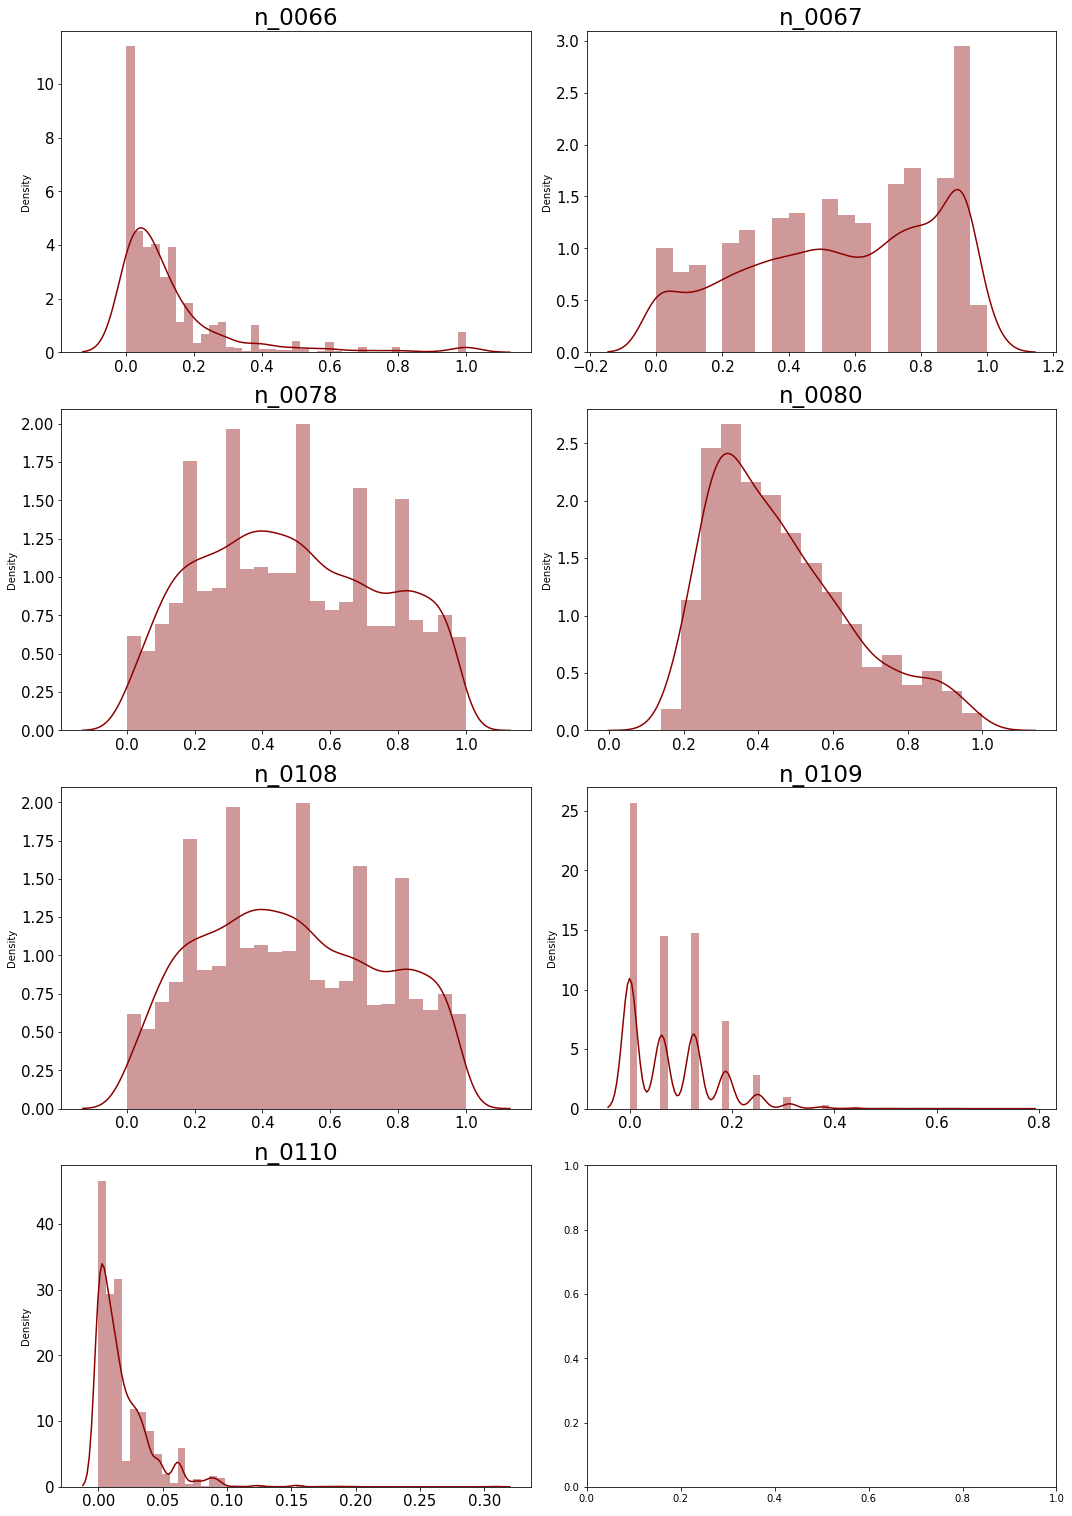

In [22]:
cols_for_plot = n_cols_num_good + list(itemgetter(*[17, 20, 31])(n_cols_num_not_bad))
cols_for_plot.sort()
cols_for_plot


fig, axes = plt.subplots(nrows = 4, ncols = 2, figsize = (15, 23))

for ax, column in zip(axes.flatten(), train[cols_for_plot].columns):
    sns.distplot(train[column], ax = ax, color = 'darkred')
    
    ax.set_title(column, fontsize = 23)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = 15)
    ax.set_xlabel('')
    
fig.tight_layout(rect = [0, 0.03, 1, 0.95])

Как видим, соседние номера нефига не похожи друг на друга, поэтому зафиллить плохого соседа по подобию хорошего не получится.

<br>Но у нас тут номера 8кой на конце совпали по распределениям, проверим.

Хмм, есть похожие, так даже можно корреляции убрать, но в общем и целом они разные.

Следующую задачу я бы тогда сформулировал неформально так:
<br>у меня есть одномерные эмпирическая плотность / функция распределения (все равно, для чего решать) и теоретическая.
<br>Хочется понять, с какого объема $N$ выборки $X[N]$ можно нашу эмпирическую функцию назвать почти похожей на теоретическую.

Это позволит нам как раз таки выбрать порог для almost_bad_cols (сейчас он = 1000, но без каких-либо теор обоснований).

Попробуем достать из гистограм эмпирические плотности, либо посчитать руками, если не получится готовое достать.
<br>Потом найдем $N$ для заданной погрешности и переделим (возможно) колонки на almost_bad и good.

---

### Density Estimation

Пусть выборка $X_{[n]} \sim \rho$ (какой-то абсолютно - непрерывной плотности). Есть реализованная выборка, как оценить $\rho$?

<br>Мы знаем несмещенную, состоятельную, почти наверное равномерно сходящуюся (т-ма Гливенко — Кантелли) оценку ф.р.: $\hat{F_n}(x) = \frac{1}{n} \sum\limits_{i=1}^{n} I_{\{x_i \leq x \}}$. <br>Но у этой функции не во всех точках существует производная, а где существует = 0 (не содержательно).

Попробуем действовать по определению. $P(a < X \leq b) = F(b) - F(a) = \int\limits_{a}^{b} \rho(t) dt \approx h \rho(x)$, где $a = X - \frac{h}{2}, \ b = X + \frac{b}{2}$. <br>Т.е. $\rho(X) \approx \frac{P(X - \frac{h}{2} < X \leq X + \frac{h}{2})}{h}, h \rightarrow 0$. Тогда естественно выбрать $\hat{\rho_n}(x) = \frac{\# \{i \ : \ X - \frac{h}{2} < X_i \leq X + \frac{h}{2} \}}{n h}$.

Отсюда взялась **гистограмма** на выбранных center points $\{ c_i \} \ : \ \beta_i := (c_i - \frac{h}{2}, c_i + \frac{h}{2}]$ не пересекаются и в объеденении дают область определения. **Гистограмма** - оценка плотности : $\hat{\rho_n}(x) = \frac{1}{nh} \# \{i \ : \ x_i \in \beta_j \}$.

Но, как мы видим, такая оценка зависит от $h$.

<br>---

<br>Тогда зададимся вопросов: как оценить **близость** уже построенной **$\hat{\rho_{n}}(x)$ и $\rho(x)$**?
<br>Естественно вспомнить про квадратичную ошибку: $\left(\hat{\rho_{n}}(x) - \rho(x) \right)^{2}$. Но такой объект зависит и от выборки, и от точки $x$.
<br>Избавимся от привязки к выборке: $MSE(\hat{\rho_{n}}(x)) = {\rm I\!E} \left(\left(\hat{\rho_{n}}(x) - \rho(x) \right)^{2}\right)$, 
<br>а затем избавимся от привязки к точке $x$: $MISE(\hat{\rho_{n}}(x)) = \int {\rm I\!E} \left(\left(\hat{\rho_{n}}(x) - \rho(x) \right)^{2}\right) dx$.

Вспомним про *Bias-Variance Decomposition* и применим сначала для $MSE$, а потом и для $MISE$:
<br>$MSE(\hat{\rho_{n}}(x)) =  {\rm I\!E} \left[ \left(\hat{\rho_{n}}(x) - {\rm I\!E}(\hat{\rho_{n}}(x)) + {\rm I\!E}(\hat{\rho_{n}}(x)) - \rho(x) \right)^{2} \right] = {\rm I\!D} (\hat{\rho_{n}}(x)) + 2 \cdot 0 + \left( {\rm I\!E}(\hat{\rho_{n}}(x)) - \rho(x) \right)^{2} = {\rm I\!D} (\hat{\rho_{n}}(x)) + Bias^{2} (\hat{\rho_{n}}(x))$.
<br>$MISE(\hat{\rho_{n}}(x)) = \int Bias^{2} (\hat{\rho_{n}}(x)) dx + \int {\rm I\!D} (\hat{\rho_{n}}(x)) dx$.
<br>Соответственно, выбираем $h$, минимизирующее $MISE$, ибо это мера похожести, а, следовательно, предпочтительны нулевые значения.

<br>Для *гистограммы* на $[0, 1]$ имеем: $h_{opt} \sim n^{-\frac{1}{3}}, MISE \sim n^{-\frac{2}{3}}$; 
$$ \ h_{opt} = \left( \frac{6}{n \int\limits_{0}^{1} (\rho ' (x))^{2} dx} \right) ^{\frac{1}{3}}$$
<br>В пакетах основных предполагается, что $\rho(x) \sim N(0, \sigma^{2})$. Тогда $h_{opt} = (24 \sqrt{n})^{\frac{1}{3}} \hat{\sigma_n} n^{-\frac{1}{3}}$ - *метод Скотта*.

<br>---

<br>Передем к **ядерным оценкам** плотности.
<br>*Ядра* ${\rm I\!K}$ сами по себе являются плотностями, но обычно берут только четные.

$$\hat{\rho_n}(x) = \frac{1}{nh} \sum\limits_{i=1}^{n} {\rm I\!K}\left( \frac{x - x_i}{h} \right)$$

$\frac{|x - x_i|}{h} \leq 1 \ \Rightarrow \ x_i - h \leq x \leq x_i + h$. Суть в том, что в таких окрестностях сумма увеличивается на значение ядра (аналог весов), а на пересечениях окрестностей значение плотности будет наибольшим. Такой метод позволяет учитывать концентрацию точек.

${\rm I\!E}\left(\hat{\rho_n}(x) \right) = \frac{1}{nh} \sum\limits_{i=1}^{n} {\rm I\!E} \left[ {\rm I\!K}\left( \frac{x - x_i}{h} \right) \right] = \frac{1}{nh} \sum\limits_{i=1}^{n} {\rm I\!K} \left( \frac{x-y}{h} \right) \rho(y) dy = \frac{1}{nh} \sum\limits_{i=1}^{n} \int\limits_{-\infty}^{+\infty} {\rm I\!K}(u)\rho(x - uh) h du \ \rightarrow_{h \rightarrow 0} \ \frac{1}{n} \sum\limits_{i=1}^{n} \int\limits_{-\infty}^{+\infty} {\rm I\!K}(u) \rho(x) du = \rho(x)$, 
<br>где $\rho(y)$ - истинная (теоретическая) функция плотности. Имеем асимптотически несмещенную оценку теоретической плотности.

<br>Применим к *ядерным оценкам* BVD и найдем $h_{opt}$. 

$$MISE \left( \hat{\rho_n}(x) \right) = \left[ \frac{1}{4} h^{4} + \int \left( \rho(x) \right)^{2} dx \cdot \left( x^{2} {\rm I\!K}(x) dx \right)^{4} + \frac{1}{nh} \int {\rm I\!K}^{2}(x) dx \right] \left[1 + o(1)\right]$$

Первые два слагаемых - интеграл от $Bias^{2} (\hat{\rho_n}(x))$, третье слагаемое - интеграл от ${\rm I\!D} (\hat{\rho_{n}}(x))$.

Тогда на $[0, 1]$ имеем: $h_{opt} \sim n^{-\frac{1}{5}}, MISE \sim n^{-\frac{4}{5}}$; 
$$ \ h_{opt} = n^{-\frac{1}{5}} \left( \frac{\int {\rm I\!K}^{2} (x) dx}{\int {\rm I\!K}(x) x^2 dx \cdot \int \left( \rho '' (x) \right)^{2} dx} \right) ^{\frac{1}{5}}$$
<br>В пакетах основных предполагается, что $\rho(x) \sim N(0, \sigma^{2})$ и ${\rm I\!K} (x) = \frac{1}{\sqrt{2\pi}} e^{-\frac{x^{2}}{2}}$. Тогда $h_{opt} = \left( \frac{4}{3} \right)^{\frac{1}{5}} \cdot \min(\hat{\sigma_n}, \frac{IQR}{1.34}) \cdot n^{-\frac{1}{5}}$.

<br>---

<br>**Теорема (Van der Vaart)**:
<br>${\rm I\!P}_{m}$ - семейство абсолютно - непрерывных плотностей таких, что $\rho(x)$ $m$-раз дифференцируемо и $\int\limits_{-\infty}^{+\infty} \left( \rho^{(m)}(x) \right)^{2} dx < \infty$.
<br>Тогда верно следующее: $$\forall \hat{\rho_n}(x)  \quad \sup\limits_{\rho \ \in \ {\rm I\!P}_{m}} {\rm I\!E} \left[ \int\limits_{-\infty}^{+\infty} \left( \hat{\rho_n}(x) - \rho(x) \right)^{2} dx \right] \geq C \cdot n^{-\frac{2 m}{2 m + 1}}$$
<br>Т.е. какую бы мы не взяли оценку $\hat{\rho_n}(x)$, она не будет равномерно лучше в смысле ошибки $MISE$ на всем классе ${\rm I\!P}_{m}$, чем выражение справа в неравенстве, хотя на отдельных $\rho(x)$ может давать и меньшую ошибку $MISE$.

Тогда имеем, что *гистограмма* лучшая в классе ${\rm I\!P}_{1}$, а *ядерные оценки* лучшие в классе ${\rm I\!P}_{2}$.

<br>---

$$MISE(h_{opt}) = \left[ \frac{5}{4} n^{-\frac{4}{5}} \left( \int x^{2} {\rm I\!K}(x) dx \right)^{\frac{2}{5}} \left( \int {\rm I\!K}^{2}(x) dx \right)^{\frac{4}{5}} \cdot \int \left( \rho(x) \right)^{2} dx \right] \left[1 + o(1) \right]$$
Видим, что хорошо разложилось на множетели только с $ {\rm I\!K}(x)$ и только с $\rho(x)$. Давайте выберем $ {\rm I\!K}(x) $ такое, что оно будет минимизировать $MISE$. 

$$K_{opt} = \ <ядро \ Епанечникова> \ = \frac{3}{4} \left( 1 - x^{2} \right) I_{\{ |x| \leq 1 \}}$$ 

Но на самом деле остальные ядра не многим хуже. А тогда, получается, от ядра особо то ничего и не зависит, раз они все примерно одинаковые с точки зрения минимизации $MISE$.

---

Давайте напоследок поймем, с какого объема $N$ выборки $X[N]$ можно нашу эмпирическую плотность назвать почти похожей на теоретическую.

<br>Мы знаем для ядерных оценок (да и для гистограммы) оценку на разницу жмпирической и (неизвестной) теоретической плотностей.
<br>Достаточно правильно было бы считать по $N \rightarrow +\infty$  $logloss$ и смотреть, при каком $N$ лучше (хотя и можем переобучнуться). Но это долго и затратно.

<br>Даже, по всей видимости, можно сказать больше: оптимально предположить какое-то распределение, запараметризовать его, параметрическими методами найти параметры, а после этого фиксировать $\epsilon$  и подбирать $N \ : MISE\left( \hat{\rho_n}(x) \right) < \epsilon$ (впервые $< \epsilon$). Но это для каждого столбца нужно тыкать на бум в функцию распределения, для каждого столбца параметризовать, а потом еще надеяться, что с 1го раза $MISE$ станет маленьким относительно быстро (что означает, что мы правильно угадали и подобрали).

В общем, чисто из интуитивных (не подкрепленных теорией) соображений будем считать, что при $N > 1000$ эмпирическую плотность можно считать похожей на теоретическую. И будем восстанавливать плотность только для таких столбцов.

Посмотрим сначала, как восстанавливается плотность на одном столбце.

In [23]:
train[n_cols_num_not_bad[3]].isnull().sum()

2464

Выглядит подходящим экземпляром.

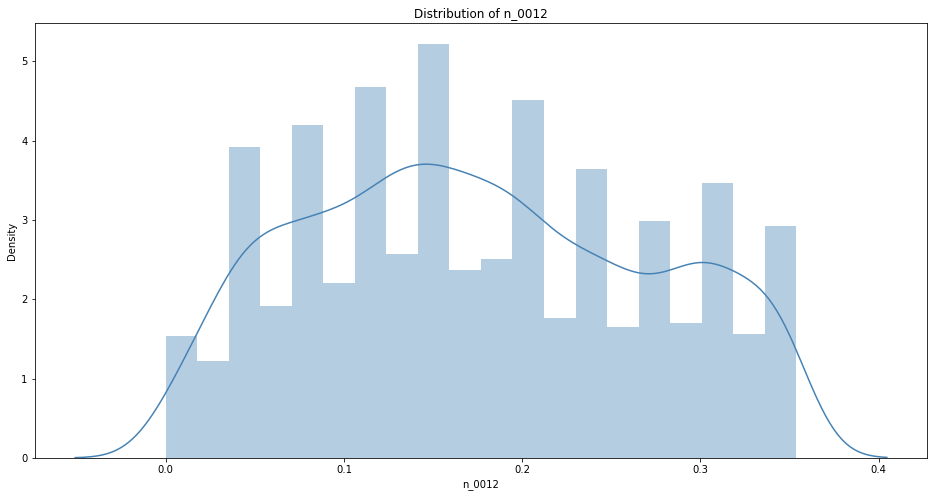

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))

ax.set_title('Distribution of ' + n_cols_num_not_bad[3])
ax.set_xlabel(n_cols_num_not_bad[3])

sns.distplot(train[n_cols_num_not_bad[3]], color = 'steelblue')
plt.show()

In [25]:
import math
from statsmodels.distributions.empirical_distribution import ECDF
from statistics import stdev

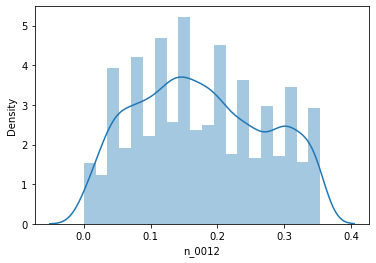

In [26]:
ecdf = ECDF(sns.distplot(train[n_cols_num_not_bad[3]]).get_lines()[0].get_data()[0])

In [27]:
print('P(x<0.1): %.3f' % ecdf(0.1))
print('P(x<0.2): %.3f' % ecdf(0.2))
print('P(x<0.3): %.3f' % ecdf(0.3))

P(x<0.1): 0.330
P(x<0.2): 0.550
P(x<0.3): 0.770


Хммм, вероятности то, вероятно, эта штука и выдает разумные, но как генерировать то новые данные, а не подставлять значения..

<br>Напишем руками написать эмпирическую плотность.

In [28]:
def h_bin(x):
    
    return math.pow(4/3, 1/5) * min(stdev(x), sp.stats.iqr(x) / 1.34) * math.pow(len(x), -1/5)


def gauss_kernel(x):
    
    return 1 / math.sqrt(2 * math.pi) * math.exp(-math.pow(x, 2) / 2)


def empirical_density(sample, values,
                      density_probs):
    density_probs = []
    h = h_bin(sample)
    
    for j in range(len(values)):
        rho_j = 0
        
        for i in range(len(sample)):
            K_j = gauss_kernel((values[j] - sample[i]) / h)
            rho_j += K_j
            
        rho_j = 1 / (len(sample) * h)
        density_probs.append(rho_j)
        
    
    return density_probs

Так, Я ТУТ ПОНЯЛ, что написал эмпирическую плотность, а она возвращает **вероятности**, а мне **значения** нужны, которые я как раз зачем-то передаю 2м аргументом (values). Сейчаааасс.. А когда тогда генерятся выборки из распределений разных?

Вот у меня есть $U(0, 1)$ распределение, как мне выборку из него нагенерить? Не в плане библиотеки, а дайте принцип, метод или формулу. А то я сейчас запутался.. *Вероятности по значениям* то я могу  получать, а вот *значения из распределения* как получать?

Кажется, пора спать. И минус много времени.. уфф

Вот пошел, и через 5 минут понял, что я очень вовремя (сарказм) сформулировал математически задачу, которую затеял:
<br>мне нужно, на самом деле, восстановить функцию распределения, обратить ее и нагенерить по обратной функции выборку,
<br>а я восстановил плотность. Ну, интегралы брать мы уже не будем, как и обращать.

Если честно, по-видимому, тут все столбцы из $[0; 1]$. Такое можно интерпретировать как вероятности, а вероятности я уже умею генерировать.

Еще нагуглил Copula -- апргрейженная моя идея, по-видимому, восстановления плотности и генерации выборки на ее основе.

---

## Gaps filling: part III

Давайте из простого заодно проверим kNN, прежде чем переходить к продвинутым техникам.

In [5]:
from sklearn.impute import KNNImputer

In [6]:
numeric_cols = list(train.select_dtypes(include=numerics).columns)
string_cols = list(train.select_dtypes(include='object').columns)

print(len(numeric_cols), len(string_cols))

277 911


In [7]:
mask = train[numeric_cols].isnull().sum() == 0
numeric_good_cols = list(train[numeric_cols].columns[mask])

mask = (train[numeric_cols].isnull().sum() < 1029) & (train[numeric_cols].isnull().sum() > 0)
numeric_almost_good_cols = list(train[numeric_cols].columns[mask])

mask = (train[numeric_cols].isnull().sum() > 1028) & (train[numeric_cols].isnull().sum() < 8000)
numeric_not_bad_cols = list(train[numeric_cols].columns[mask])

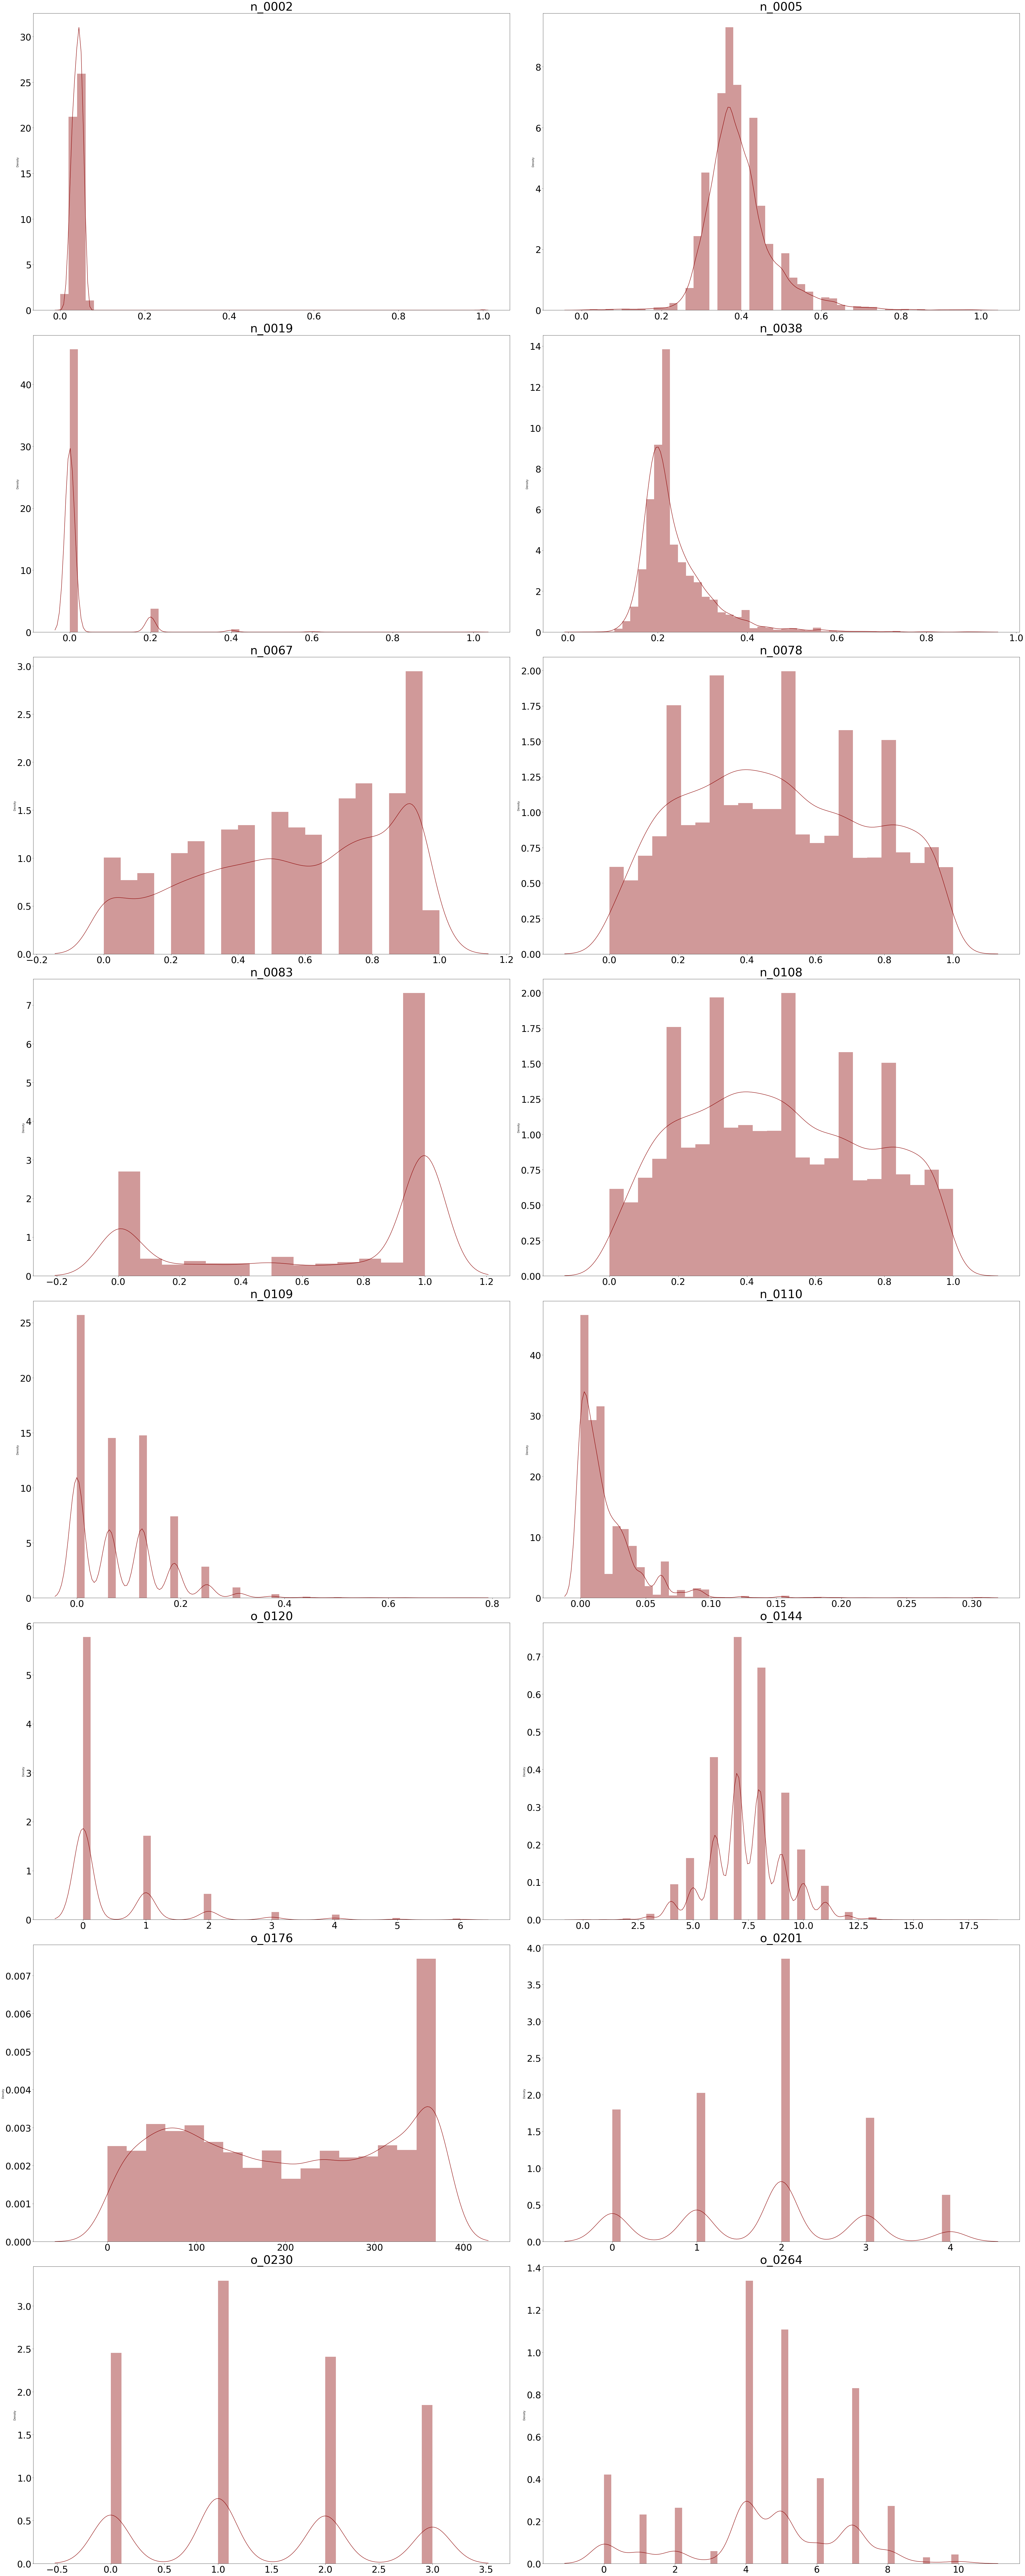

In [8]:
cols_for_plot = numeric_good_cols + numeric_almost_good_cols
cols_for_plot.sort()


fig, axes = plt.subplots(nrows = 8, ncols = 2, figsize = (55, 150))

for ax, column in zip(axes.flatten(), train[cols_for_plot].columns):
    sns.distplot(train[column], ax = ax, color = 'darkred')
    
    ax.set_title(column, fontsize = 45)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 35)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = 35)
    ax.set_xlabel('')
    
fig.tight_layout(rect = [0, 0.03, 1, 0.95])

In [9]:
%%time
knn_numeric_fill = numeric_almost_good_cols + numeric_not_bad_cols

train_numeric_knn = train[knn_numeric_fill].copy()
tr_cols = list(train_numeric_knn.columns)

imputer = KNNImputer(n_neighbors=6, weights='distance', metric='nan_euclidean')
train_numeric_knn = imputer.fit_transform(train_numeric_knn)

train_numeric_knn = pd.DataFrame(data=train_numeric_knn, columns=tr_cols)
train_numeric_knn.head()

Wall time: 1min 17s


,n_0002,n_0005,n_0019,n_0038,n_0083,n_0110,o_0120,o_0144,o_0201,o_0230,...,o_0314,o_0315,o_0316,o_0319,o_0321,o_0322,o_0323,o_0324,o_0325,o_0326
0,0.025449,0.368421,0.0,0.193548,1.000000,0.009231,0.0,8.0,0.0,1.0,...,0.0,0.0,3.595414,6.924297,1.261390,19.858683,0.0,1.723561,0.339476,5.788092
1,0.031297,0.315789,0.0,0.177419,0.000000,0.009231,0.0,8.0,2.0,2.0,...,0.0,0.0,0.000000,6.460700,1.134780,19.256544,0.0,1.784041,0.496378,4.321955
2,0.024475,0.342105,0.0,0.290323,1.000000,0.006154,0.0,7.0,1.0,0.0,...,0.0,0.0,6.832661,4.930598,1.085414,19.065640,0.0,1.509850,0.556376,3.558836
3,0.041694,0.447368,0.0,0.370968,0.833333,0.000000,2.0,8.0,1.0,0.0,...,0.0,0.0,6.278400,4.517391,0.581190,19.494139,0.0,1.533688,0.564914,5.933225
4,0.038120,0.315789,0.0,0.177419,0.666667,0.015385,0.0,8.0,2.0,1.0,...,0.0,0.0,6.464583,5.244600,0.693781,19.218365,0.0,1.815058,0.528307,4.694341


In [10]:
mask = train[string_cols].isnull().sum() == 0
string_good_cols = list(train[string_cols].columns[mask])

mask = (train[string_cols].isnull().sum() < 1050) & (train[string_cols].isnull().sum() > 0)
string_almost_good_cols = list(train[string_cols].columns[mask])

mask = (train[string_cols].isnull().sum() > 1049) & (train[string_cols].isnull().sum() < 8000)
string_not_bad_cols = list(train[string_cols].columns[mask])

In [11]:
%%time
knn_string_fill = string_almost_good_cols + string_not_bad_cols
train_string_knn = train[knn_string_fill].copy()
tr_cols = list(train_string_knn.columns)

train_string_knn = train_string_knn.fillna('')
for col in train_string_knn.columns:
    train_string_knn[col] = LabelEncoder().fit_transform(train_string_knn[col])

imputer = KNNImputer(n_neighbors=6, weights='distance', metric='nan_euclidean')
train_string_knn = imputer.fit_transform(train_string_knn)

train_string_knn = pd.DataFrame(data=train_string_knn, columns=tr_cols)
train_string_knn.head()

Wall time: 1.5 s


,c_0368,c_0401,c_0426,c_0444,c_0456,c_0461,c_0543,c_0544,c_0554,c_0582,...,c_1365,c_1366,c_1367,c_1369,c_1370,c_1373,c_1374,c_1375,c_1376,c_1377
0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0,0.0,0.0
1,2.0,1.0,2.0,1.0,1.0,1.0,2.0,5.0,1.0,6.0,...,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,2.0,1.0,1.0,1.0,1.0,2.0,3.0,3.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0
3,2.0,1.0,1.0,1.0,1.0,1.0,3.0,3.0,1.0,1.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.0,1.0,2.0,1.0,1.0,2.0,3.0,1.0,1.0,6.0,...,2.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0


In [12]:
print(train_numeric_knn.shape)
print(train_string_knn.shape)

(8000, 271)
(8000, 892)


In [13]:
train_knn_ohe = OneHotEncoder(handle_unknown="ignore").fit_transform(train_string_knn)
train_knn_ohe = pd.DataFrame.sparse.from_spmatrix(train_knn_ohe)

train_knn = pd.concat([train_numeric_knn, train_knn_ohe], axis=1, join="inner")
train_knn.shape

(8000, 6381)

---

## Model I.3

In [14]:
lr = LogisticRegression(
    solver='lbfgs',
    random_state=42,
    n_jobs=-1
)

cbc = CatBoostClassifier(verbose=0)


models = {
    'LR': lr,
    'CB': cbc
}
predicts = []

In [15]:
for m in range(0, len(models)):
    model = list(models.values())[m]
    model_name = list(models)[m]
        
    t0 = datetime.utcnow()
    
    for K in range(0, labels.shape[1]):
        cv_values = cross_val_score(
            model,
            train_knn,
            labels.iloc[:, K],
            cv=4,
            scoring='neg_log_loss'
        )
        
        predicts.append(-cv_values.max())
        print(model_name + " " + str(K) + " test logloss = %.4f" % predicts[K])
            
    t1 = datetime.utcnow()
    print()
    print(model_name + " took {}".format(t1 - t0))
    
    print('---------------')
    print(model_name + ' test multiclass LogLoss = %.4f' % (sum(predicts) / len(predicts)))
    print('\n')
    predicts.clear()

LR 0 test logloss = 0.3786
LR 1 test logloss = 0.5527
LR 2 test logloss = 0.5250
LR 3 test logloss = 0.0592
LR 4 test logloss = 0.2123
LR 5 test logloss = 0.0922
LR 6 test logloss = 0.1861
LR 7 test logloss = 0.4825
LR 8 test logloss = 0.0943
LR 9 test logloss = 0.3733
LR 10 test logloss = 0.4770
LR 11 test logloss = 0.1143
LR 12 test logloss = 0.1144
LR 13 test logloss = 0.3564

LR took 0:06:25.416311
---------------
LR test multiclass LogLoss = 0.2870


CB 0 test logloss = 0.3361
CB 1 test logloss = 0.5034
CB 2 test logloss = 0.5035
CB 3 test logloss = 0.0275
CB 4 test logloss = 0.1656
CB 5 test logloss = 0.0587
CB 6 test logloss = 0.1741
CB 7 test logloss = 0.4454
CB 8 test logloss = 0.0547
CB 9 test logloss = 0.3587
CB 10 test logloss = 0.4604
CB 11 test logloss = 0.0884
CB 12 test logloss = 0.0770
CB 13 test logloss = 0.3424

CB took 0:47:52.359047
---------------
CB test multiclass LogLoss = 0.2569




Лучшее было:
<br>LR test multiclass LogLoss = 0.2792
<br>CB test multiclass LogLoss = 0.2505

Занятно, что не побило обычное зафилливание + ohe :)

---